# COVID19 - Brazil States

Install necessary packages for parallel computation:

```
pip install ipyparallel
ipcluster nbextension enable
pip install parallel-execute
```

To install for all users on JupyterHub, as root:
```
jupyter nbextension install --sys-prefix --py ipyparallel
jupyter nbextension enable --sys-prefix --py ipyparallel
jupyter serverextension enable --sys-prefix --py ipyparallel
```

start cluster at jupyter notebook interface

In [1]:
import urllib.request
import pandas as pd
import numpy as np

In [2]:
# Download data
import get_data
LoadData=True

if LoadData:
    get_data.get_data()

Baixando arquivos brasil.io...


In [3]:
df = pd.read_csv("data/dados_total_estados.csv")
df

,index,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,0,2020-06-06,AC,TOTAL,state,7525,201,82,True,881935.0,12.0,853.23748,0.0267
1,1,2020-06-05,AC,TOTAL,state,7284,190,81,False,881935.0,12.0,825.91121,0.0261
2,2,2020-06-04,AC,TOTAL,state,7021,181,80,False,881935.0,12.0,796.09041,0.0258
3,3,2020-06-03,AC,TOTAL,state,6679,171,79,False,881935.0,12.0,757.31205,0.0256
4,4,2020-06-02,AC,TOTAL,state,6465,165,78,False,881935.0,12.0,733.04722,0.0255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,165494,2020-03-13,AL,TOTAL,state,1,0,5,False,3337357.0,27.0,0.02996,0.0000
2242,165495,2020-03-12,AL,TOTAL,state,1,0,4,False,3337357.0,27.0,0.02996,0.0000
2243,165496,2020-03-10,AL,TOTAL,state,1,0,3,False,3337357.0,27.0,0.02996,0.0000
2244,165497,2020-03-09,AL,TOTAL,state,1,0,2,False,3337357.0,27.0,0.02996,0.0000


In [4]:
# Model

In [5]:
states=['SP','ES','MG','RJ','PE','CE','AM']
# states=['MG','ES','SP']
states

['SP', 'ES', 'MG', 'RJ', 'PE', 'CE', 'AM']

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + \gamma \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t)
\end{array}$$

The last equation does not need to be solve because:

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.


## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed  [1/min]

$b$: recovery rate  [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

In [6]:
# Initial parameters
dfparam = pd.read_csv("data/param.csv")
dfparam = dfparam.dropna()
dfparam

,state,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,SP,2020-03-15,200,7000000.0,0,0,800,300,250,100,0.15,0.65,0.01
1,ES,2020-04-01,200,450000.0,0,0,50,10,0,100,0.15,0.65,0.00
2,MG,2020-04-01,200,1100000.0,0,0,200,100,0,100,0.15,0.55,0.01
3,RJ,2020-03-20,200,700000.0,0,0,800,150,400,100,0.15,0.50,0.01
4,CE,2020-03-20,200,800000.0,0,0,800,150,400,100,0.15,0.50,0.01
5,PE,2020-03-20,200,700000.0,0,0,800,150,400,100,0.15,0.50,0.01
6,AM,2020-03-20,200,700000.0,0,0,800,150,400,100,0.15,0.50,0.01


In [7]:
# Initial parameter optimization

In [8]:
import ray
ncpu=len(states)
ray.init(num_cpus=ncpu)

# Load solver
%reload_ext autoreload
%autoreload 2
import LearnerYabox_v2b as Learner #Yabox

2020-06-07 12:17:48,892	WARNING resource_spec.py:163 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2020-06-07 12:17:48,893	INFO resource_spec.py:205 -- Starting Ray with 120.21 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-07 12:17:50,173	WARNING resource_spec.py:163 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2020-06-07 12:17:50,174	INFO resource_spec.py:205 -- Starting Ray with 120.17 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [9]:
allStates=True
cleanRecovered=False
version="8"

results=[]
if allStates:
    for state in states:        
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        parameters
        learner = Learner.Learner.remote(state, *parameters, cleanRecovered, version)
        #learner.train()
        #add function evaluation to the queue
        results.append(learner.train.remote())
else:
    state= "ES"
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    parameters
    cleanRecovered = False
    learner = Learner.Learner.remote(state, *parameters, cleanRecovered, version)
    #learner.train()
    #add function evaluation to the queue
    results.append(learner.train.remote())

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

t/s]
  0%|          | 4950/2000000 [01:36<4:17:10, 129.29it/s]
2020-06-07 12:17:35,512	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.
2020-06-07 12:17:35,513	ERROR worker.py:1681 -- print_logs: Connection closed by server.
2020-06-07 12:17:35,519	ERROR worker.py:1781 -- listen_error_messages_raylet: Connection closed by server.
  0%|          | 4371/2000000 [01:37<5:34:27, 99.45it/s]


KeyboardInterrupt: 

In [10]:
ray.shutdown()

# Plots

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import covid_plots
import pandas as pd

In [7]:
def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

In [9]:
#select districts for plotting log plot
states4Plot=['MG',
               'SP',
               'ES',
               'CE',
               'RJ']

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 5

#versio'n to identify the png file result
version = "8"

#number of cases to start plotting model in log graph - real data = 100
startCase=100

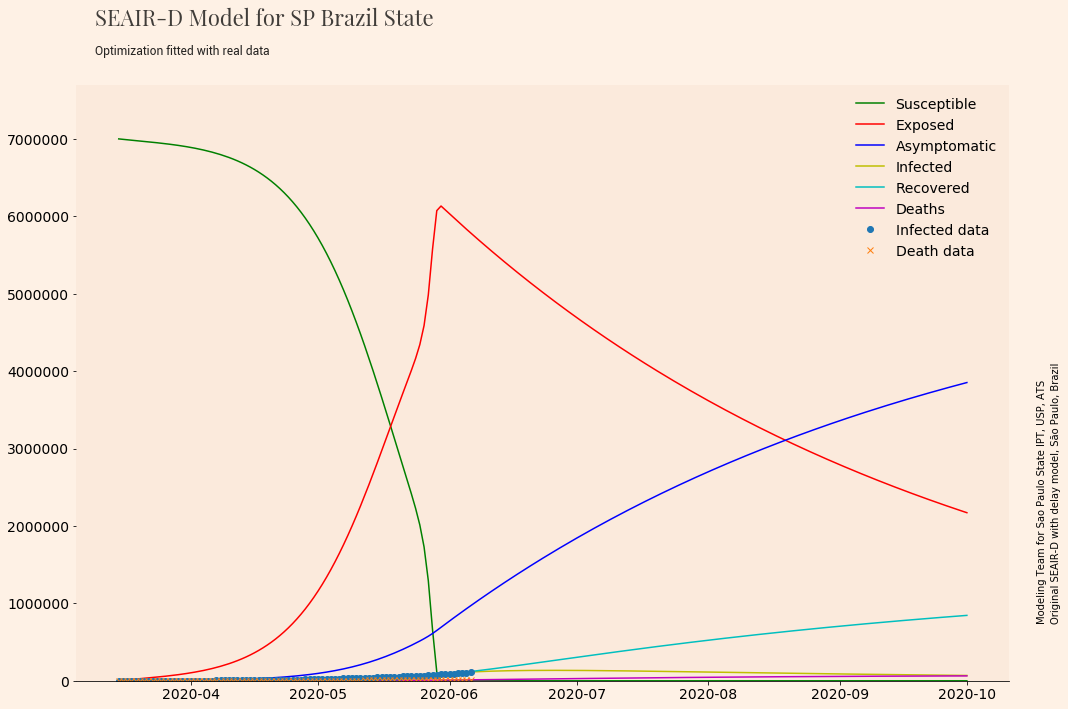

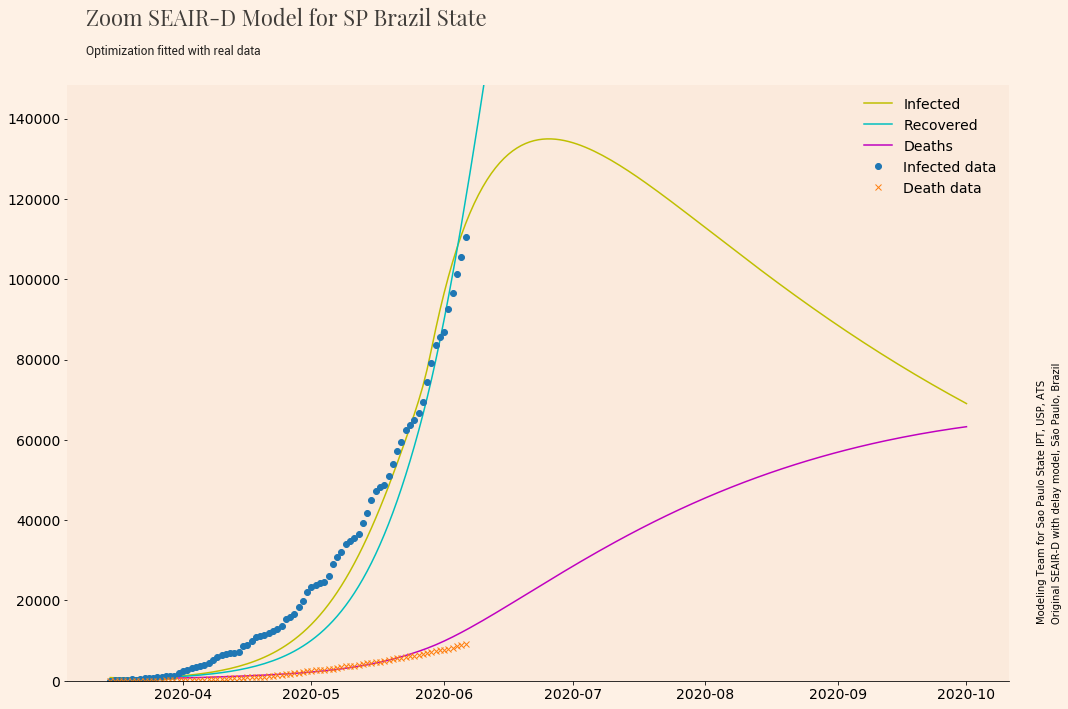

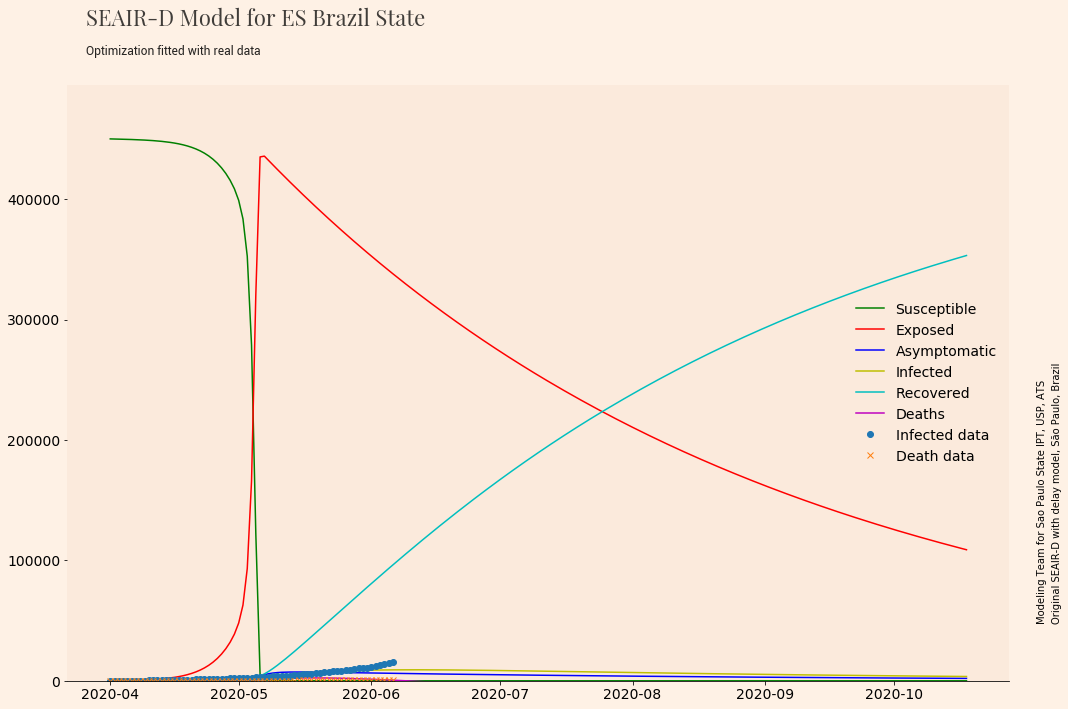

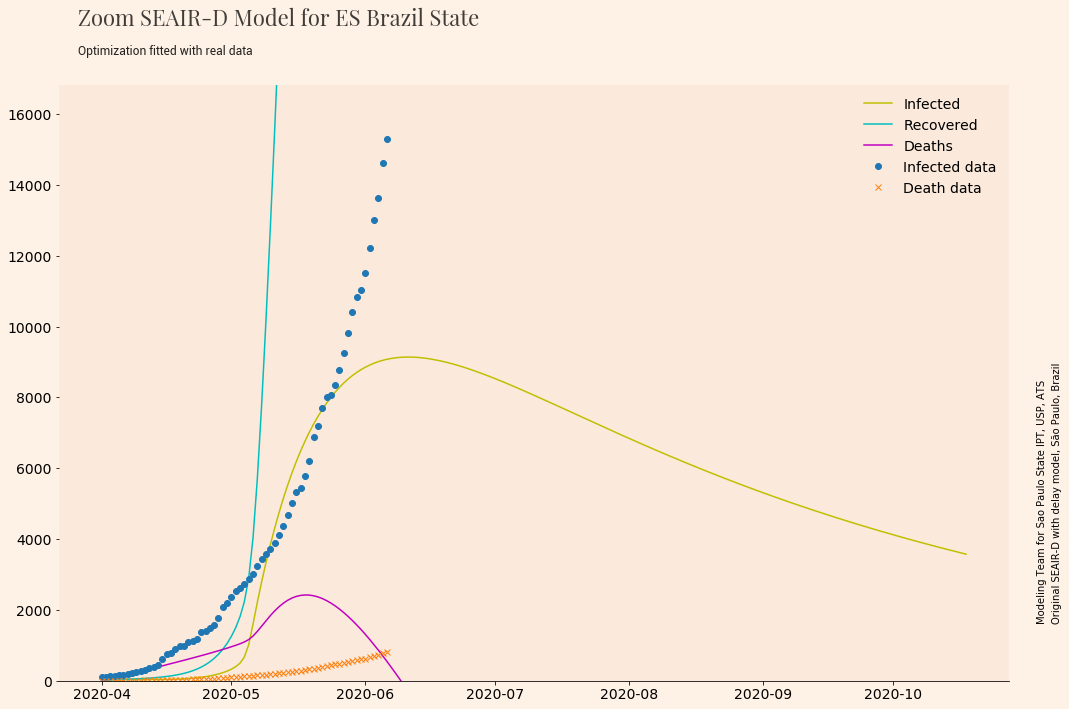

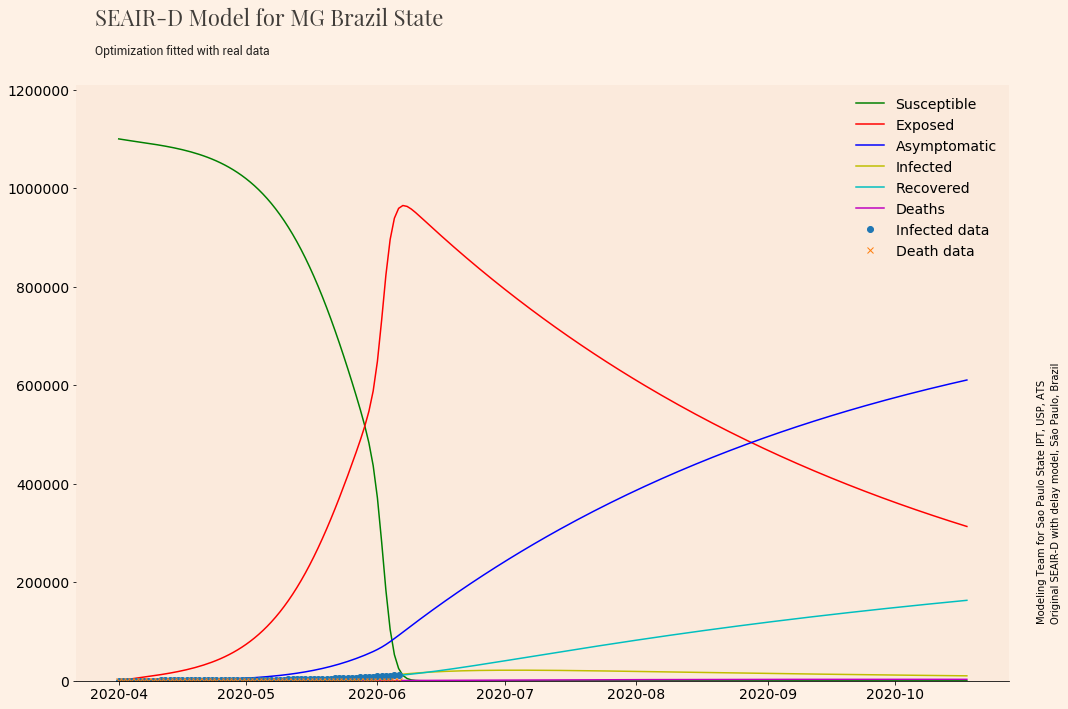

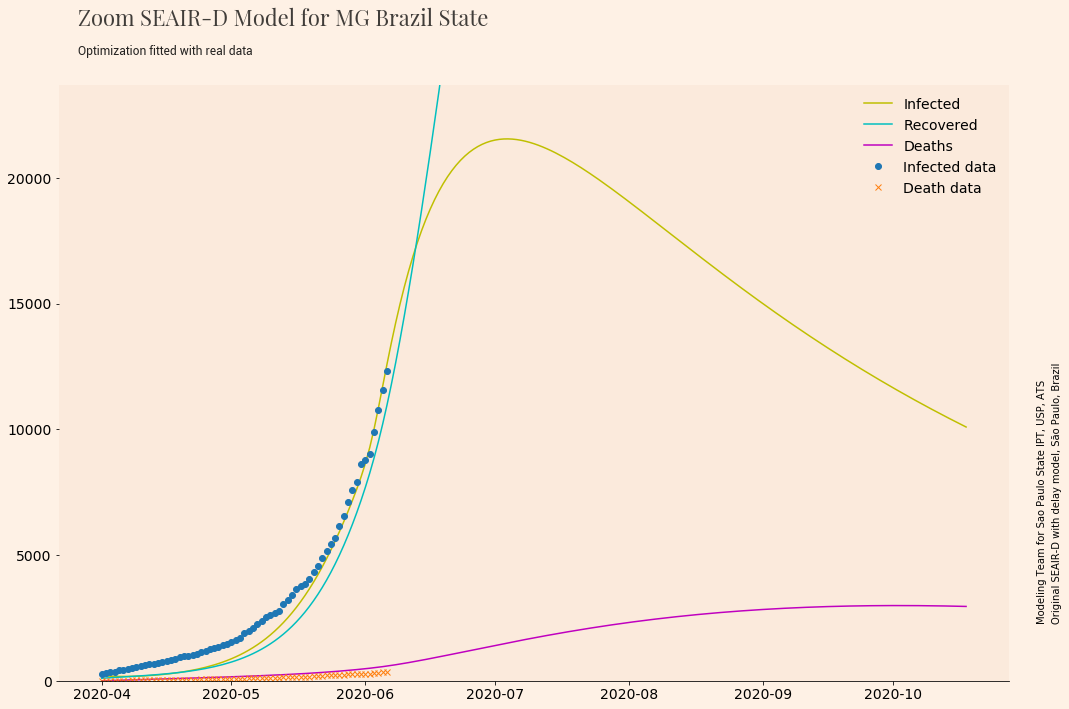

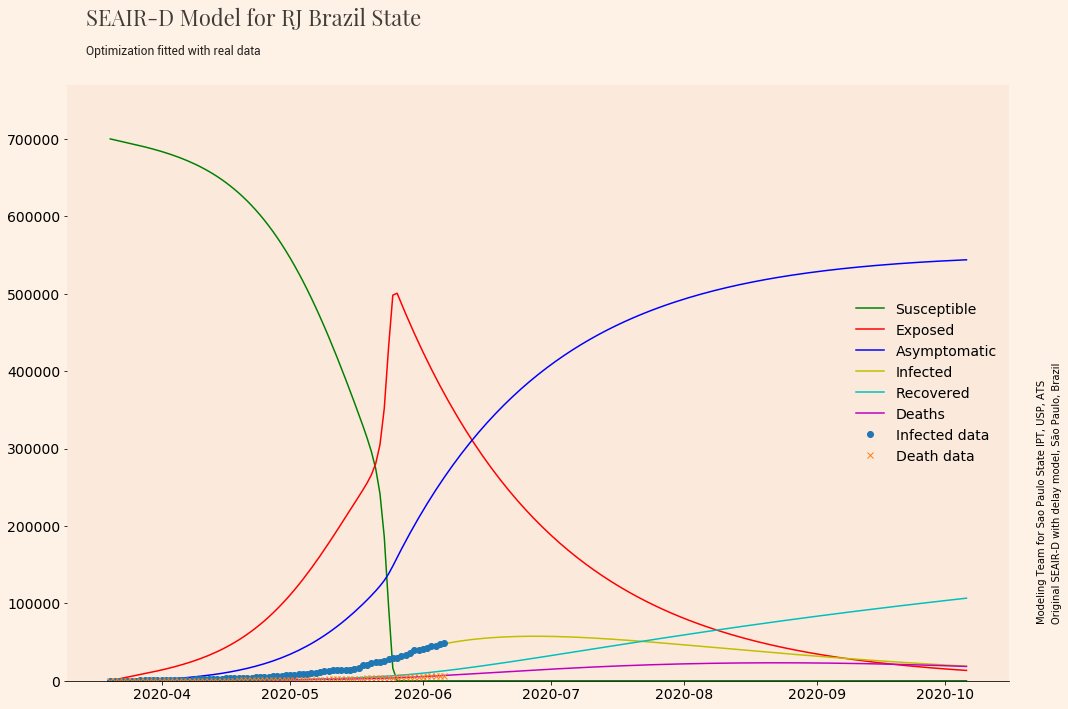

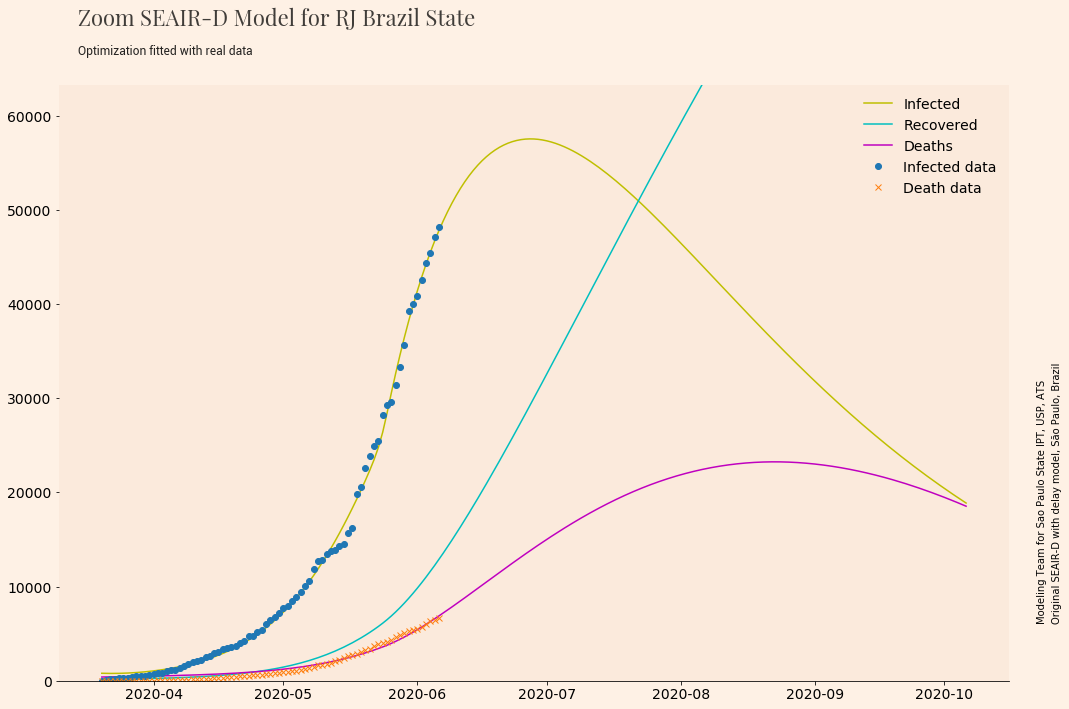

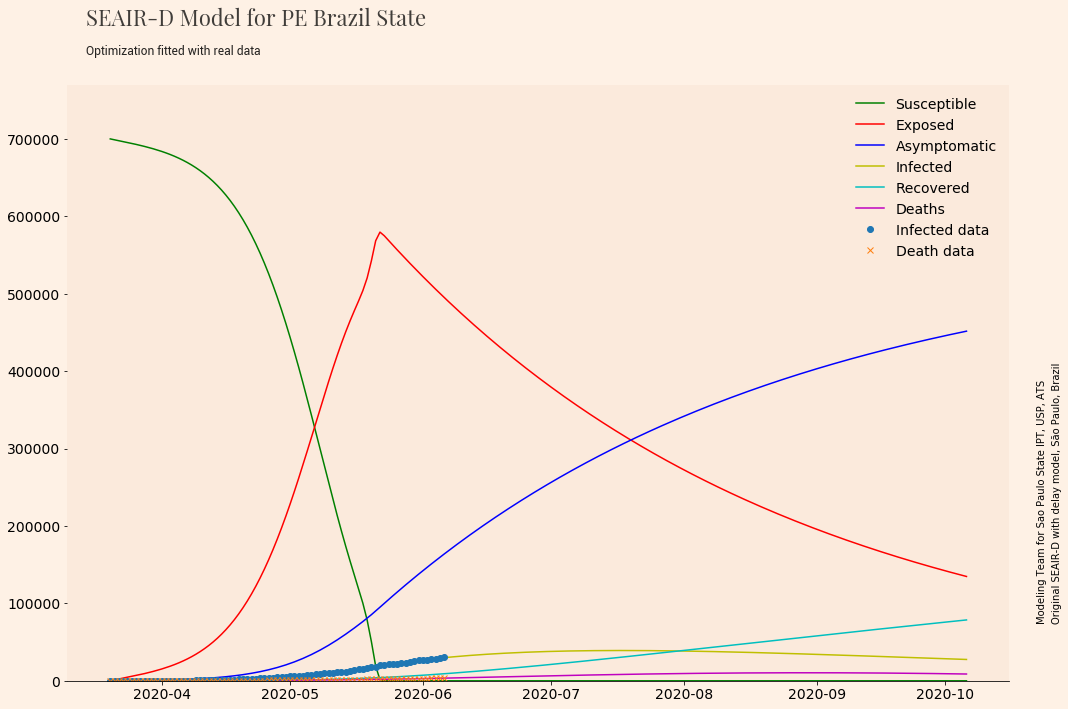

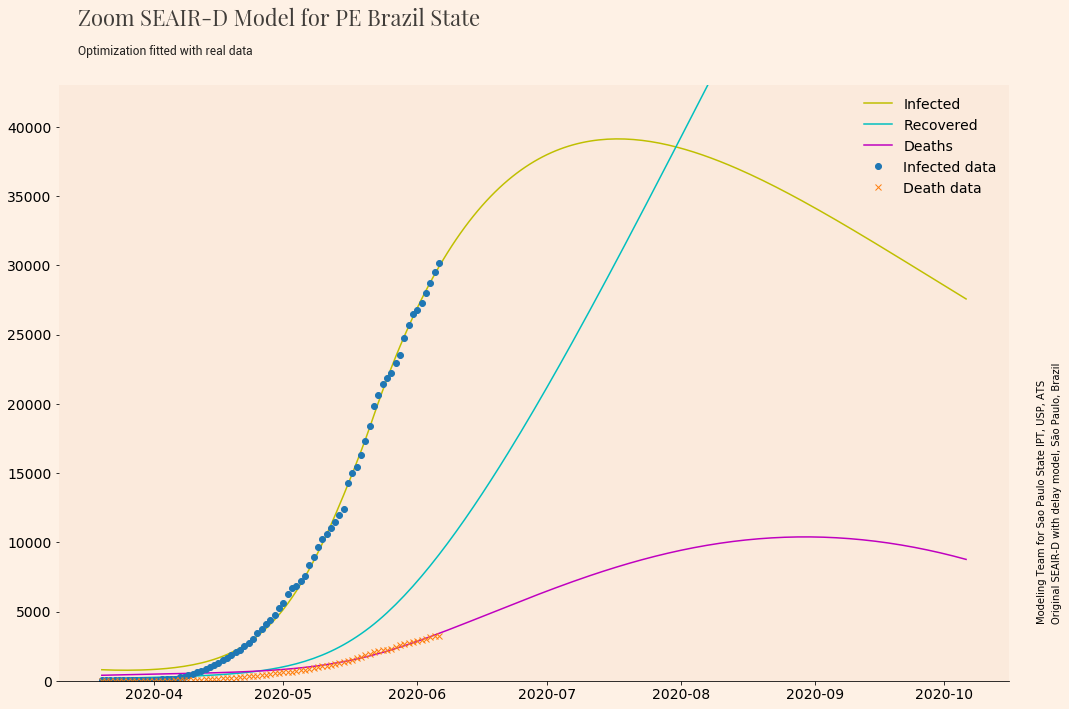

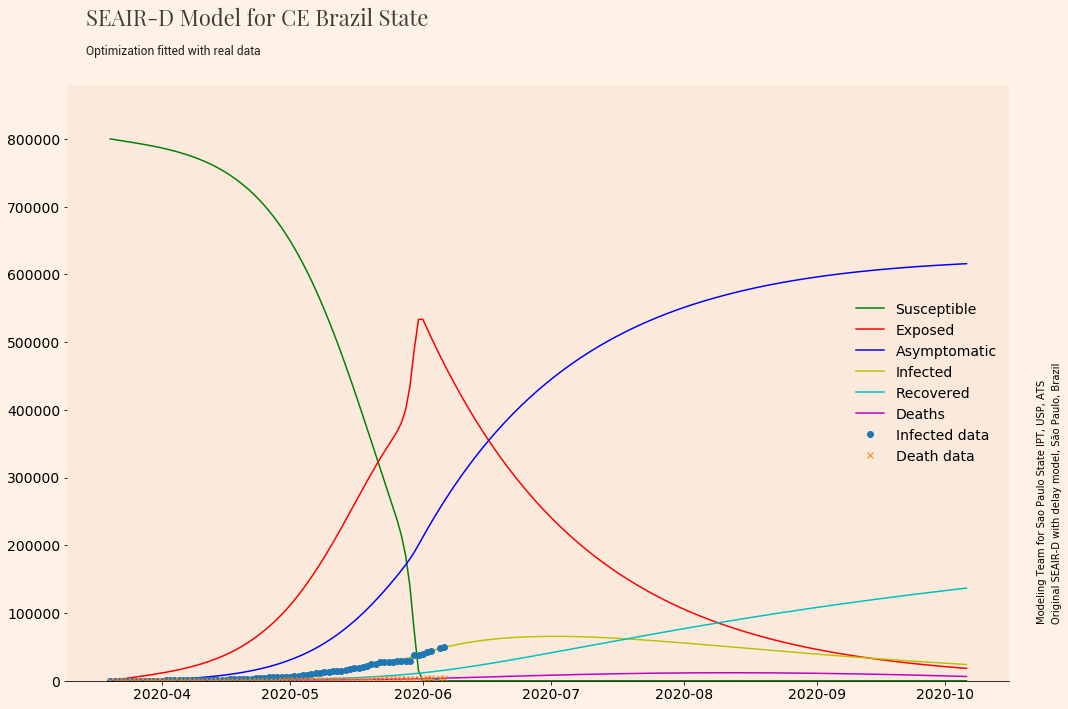

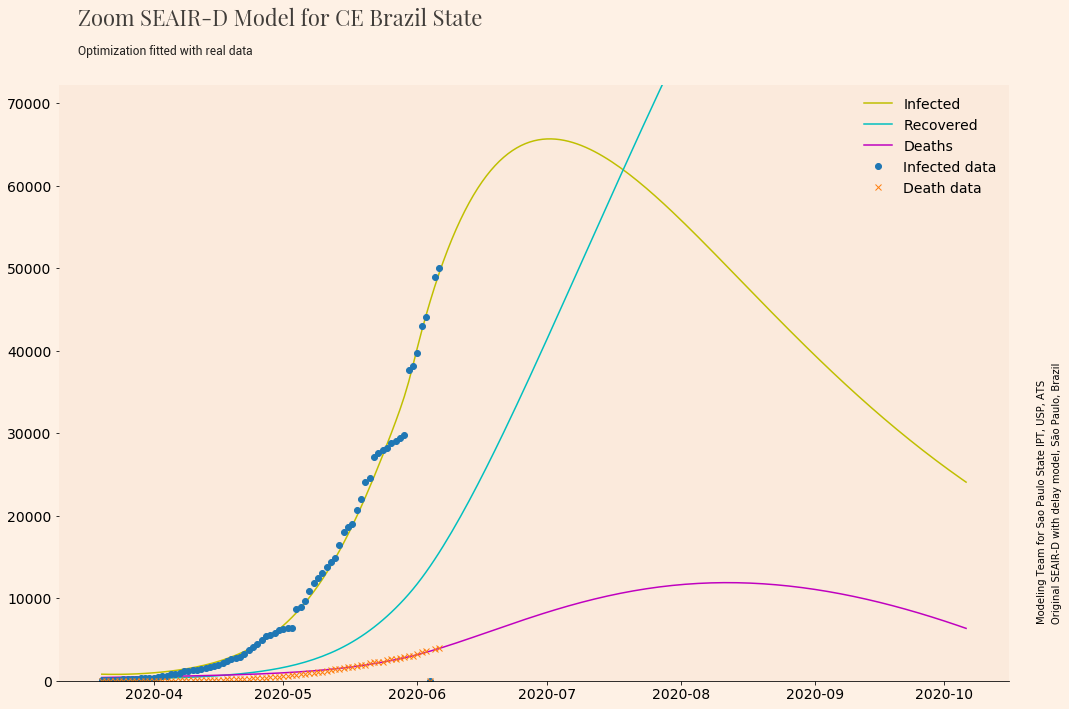

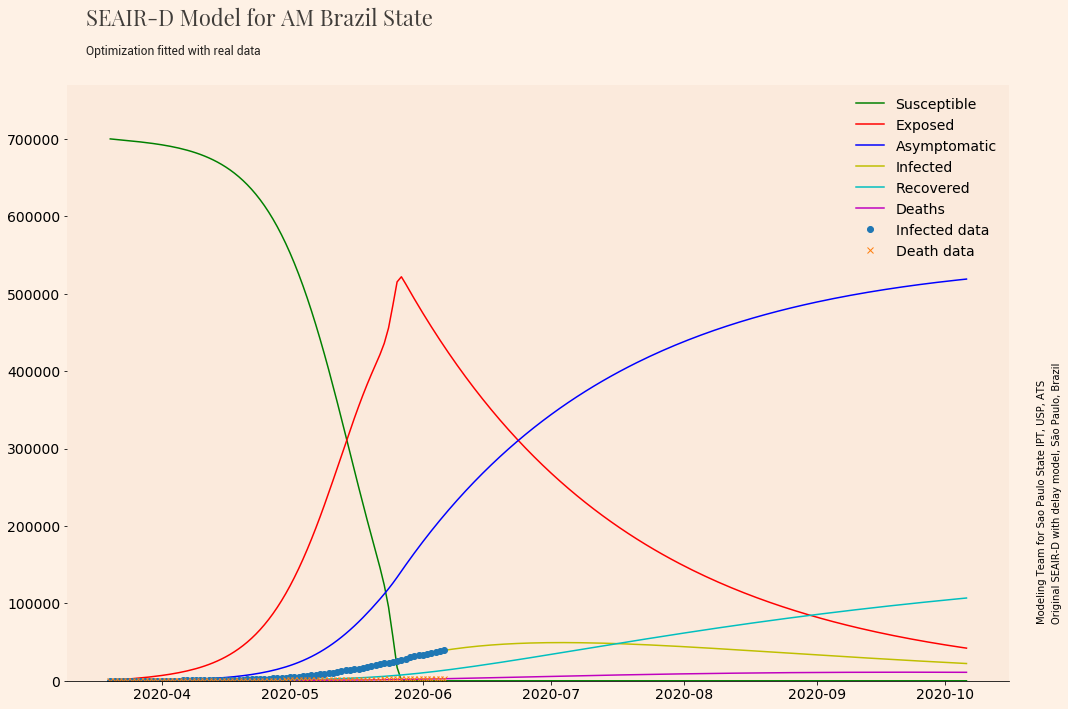

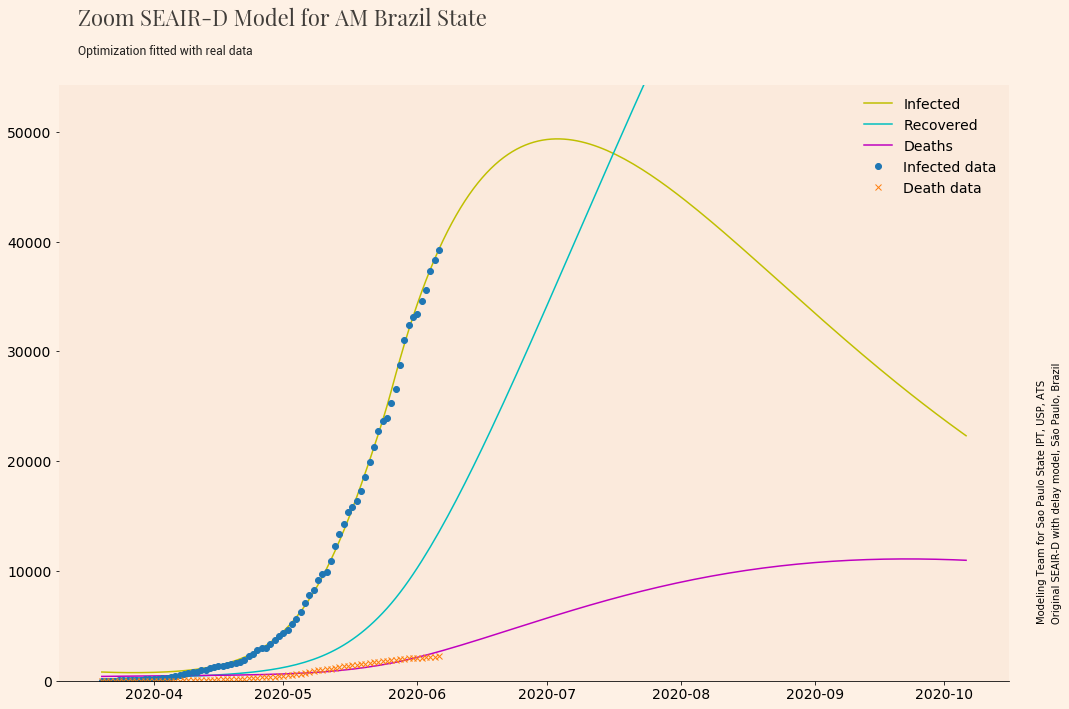

In [10]:
#plots one district or all districts
dfparam = pd.read_csv("data/param.csv")
plotStates=True

#select states for plotting
#you need to run (solve) it before plotting
if plotStates:
    states=['SP','ES','MG','RJ','PE','CE','AM']
    allStates=True

#main state for plotting log graph or SEAIRD plot
state="ES"

#if it is not SEAIRD plot, so plot one state only
if not opt==5:
    AllStates=False

if allStates:
    for state in states:
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        ratio = query['RATIO'][0]
        startCase = query['START'][0]
        startdate = query['start-date'][0]
        predict_range = query['prediction-range'][0]
        covid_plots.covid_plots(state, states4Plot, startdate,predict_range, \
                                startCase, 5, version, show=True, ratio=ratio)
else: 
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    ratio = query['RATIO'][0]
    startdate = query['start-date'][0]
    predict_range = query['prediction-range'][0]
    startCase = query['START'][0]
    covid_plots.covid_plots(state, states4Plot, startdate,predict_range, \
                                startCase, opt, version, show=True, ratio=ratio)